In [5]:
import math
import scipy
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from scipy.spatial import distance_matrix
from scipy import linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh
from scipy.fft import fft
from scipy.special import eval_gegenbauer, sph_harm

from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

#import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from tqdm import tqdm

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [6]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [7]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [8]:
dt = 450 * 10
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7101:7101+dt]

frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])

assert 490 < frequency < 510, f'Bad frequency {frequency}'
print(f'Frequency {frequency}')

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
_std = (sum((x_acc - _m)**2)/len(x_acc))**.5

x_acc = (x_acc-_m)

t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

Frequency 500.055561729081


In [9]:
X = HankelMatrix(x_acc,500)

pca_ = PCA(n_components=4)
X_PCA = pca_.fit_transform(X)

fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=1000, height=1000)

fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                             y=X_PCA[:,1],
                             z=X_PCA[:,2],
                             mode='lines'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

In [10]:
X_sp = TrajectoryToSpherical(X_PCA)
X_sp[:,-1] = 1
X_PCA_check = TrajectoryToCartesian(X_sp)

In [11]:
dist = lambda x,y: np.sum((x-y)**2)**.5
flag = False
#Checking phase area
for i in tqdm(range(len(X_PCA_check))):
    if flag:
        break
    for j in range(i, len(X_PCA_check)):
        if np.abs(i%450 - j%450) > 150 and np.abs(i%450 - j%450) < 300:
            d = dist(X_PCA_check[i],X_PCA_check[j])
            if d <= 0.1:
                print(f'Problem in {i,j} point')
                a,b = i,j
                flag = True
                break

100%|██████████| 4001/4001 [00:20<00:00, 196.83it/s]


In [ ]:
X_sp = X_sp[:,:-1]

In [ ]:
# fig_2 = go.Figure()
# fig_2.update_layout(autosize=False, width=1000, height=1000)

# fig_2.add_trace(go.Scatter3d(x=X_PCA_check[:,0],
#                              y=X_PCA_check[:,1],
#                              z=X_PCA_check[:,2],
#                              mode='markers'
#                             )
#                 )

# fig_2.add_trace(go.Scatter3d(x=X_PCA_check[a:a+1,0],
#                              y=X_PCA_check[a:a+1,1],
#                              z=X_PCA_check[a:a+1,2],
#                              mode='markers'
#                             )
#                 )

# fig_2.add_trace(go.Scatter3d(x=X_PCA_check[b:b+1,0],
#                              y=X_PCA_check[b:b+1,1],
#                              z=X_PCA_check[b:b+1,2],
#                              mode='markers'
#                             )
#                 )


# fig_2.layout.template = 'plotly_white'
# fig_2.show()

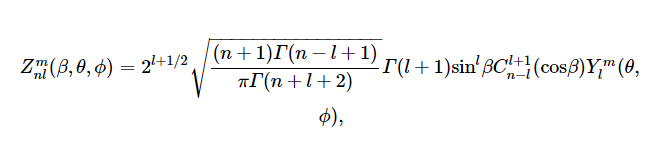

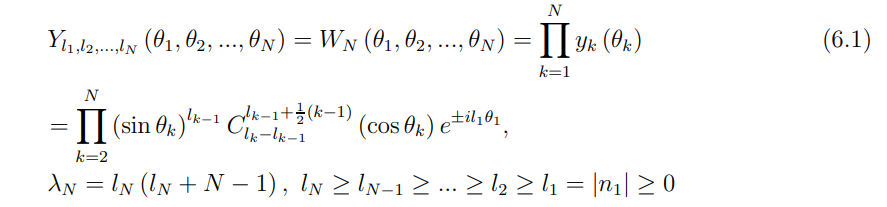

In [ ]:
G = m.gamma
Cg = eval_gegenbauer()

In [13]:
def k_c_lL(k,l,L):
    
    tmp_ans = ((2*L + k - 1) / 2) \
    * math.factorial(L + l + k - 2) \
    / math.factorial(L - l)
    
    ans = tmp_ans**.5
    return ans

In [ ]:
k_c_lL(k,l,L)

In [12]:
from scipy.special import lpmv as Associated_Legendre_func

In [17]:
def k_P_lL(k,l,L, alpha):
    
    

8.48528137423857

In [ ]:
def create_high_order_sph_harm():
    

In [ ]:
def Znml(n, l, m, beta, phi, theta):
    Znml = 2**(l+1/2) * ( (n+2)*G(n-l+1)/np.pi/G(n+l+2) )**.5\
    * G(l+1) * (np.sin(beta))**l * Cg(n-l, l+1, np.cos(beta))\
    * sph_harm(m, l, theta, phi).real
    return Znml

In [ ]:
N = 100
beta = np.linspace(0, np.pi, N)
phi = np.linspace(0, np.pi, N)
theta = np.linspace(0, 2*np.pi, N)
beta, phi, theta = np.meshgrid(beta, phi, theta)

In [ ]:
beta.shape

In [ ]:
model = []
for n in range(1):
    for l in range(n+1):
        for m in range(l+1):
            model.append(Znml(n, l, m, beta, phi, theta))
            
model = np.array(model)

In [ ]:
model.shape

In [ ]:
class sph_harm_approximation4D():
    
    def __init__(self, L_harm = 10, N = 100):
        self.L = L_harm
        self.N = N
        self.ind = 0
        
    def _makemodel_(self):
        beta = np.linspace(0, np.pi, self.N)
        phi = np.linspace(0, np.pi, self.N)
        theta = np.linspace(0, 2*np.pi, self.N)
        beta, phi, theta = np.meshgrid(beta, phi, theta)
        
        model = []
        for n in range(self.L):
            for l in range(n+1):
                for m in range(l+1):
                    model.append(Znml(n, l, m, beta, phi, theta))

        model = np.array(model)

    def fit(self, train_map):
        self.init_map = self._makemodel_()
        self.train_map = train_map
        return self
    
    def loss(self, w):
        temp_map = self.train_map.copy()*0
        
        for i in range(int(self.L*(self.L+1)/2)):
            temp_map += w[i] *  self.init_map[i]
        
        _loss = np.sum((temp_map - self.train_map)**2)
        
        if self.ind%10 == 0:
            print(f'Iter num:{self.ind}, total loss:{_loss}')
        self.ind += 1
        return _loss
    
    def div(self, w):
        _div = np.zeros_like(w)
        
        temp_map = self.train_map.copy()*0
        
        for i in range(int(self.L*(self.L+1)/2)):
            temp_map += w[i] *  self.init_map[i]

        for i in range(len(w)):
            _div[i] = np.sum(2 * (temp_map - self.train_map) * self.init_map[i])
        self._div = _div
        return _div
    
    def hess(self, w):
        _div = np.array([self._div])
        _hess = 2 * _div.T @ _div
        return _hess
    
    def set_iternum(self, iter_num = 0):
        self.ind = iter_num
    
    def predict_all(self, w):
        
        temp_map = self.train_map.copy()*0
        
        for i in range(int(self.L*(self.L+1)/2)):
            temp_map += w[i] *  self.init_map[i]
            
        return temp_map